In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import albumentations
import albumentations.pytorch
import cv2
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = 'Anime dataset'
OUT_PATH = 'output'
LOG_FILE = os.path.join(OUT_PATH, 'log.txt')
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 100
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda')

In [4]:
# image loader
class ADataset(Dataset):
    def __init__(self, transform = None):
        super().__init__()
        
        self.img_dir = "/home/temp_1/kangsanha/AnimeGan/For_pixel2style2pixel/AnimeGan/data/"
        self.filenames = os.listdir(self.img_dir)

        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.filenames[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
        # albumentations 라이브러리를 사용할 것인데, PIL을 쓰면 변환이 안된다하여 cv2로 변환해준다.
        # img = np.asarray_chkfinite(Image.open(img_path))
        
        if img.dtype == np.uint8:
            img = img / 255.0
        
        if self.transform:
            img_transform = self.transform(image=img)
            img = img_transform['image']
            
       
        return img
        

    def __len__(self):
        
        return len(self.filenames)

In [5]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.eps = 1e-8
        
    def forward(self, input):
        return input / (torch.mean(x**2, dim=1, keepdim=True)+self.eps)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN *2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN*4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [10]:
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (0.5, 0.955))
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))

In [12]:
albumentation_compose = albumentations.Compose([
    albumentations.Resize(X_DIM, X_DIM),
    albumentations.pytorch.ToTensorV2(),
])

In [13]:
dataset = ADataset(albumentation_compose)

In [14]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0) 

In [17]:
viz_noise = torch.randn(1, Z_DIM, 1, 1, device=device)

Epoch 0 [0/336] loss_D_real: 0.0185 loss_D_fake: 0.0343 loss_G: 4.9228
Epoch 0 [100/336] loss_D_real: 0.0067 loss_D_fake: 0.0391 loss_G: 5.3599
Epoch 0 [200/336] loss_D_real: 0.0123 loss_D_fake: 0.0105 loss_G: 6.2016
Epoch 0 [300/336] loss_D_real: 0.0143 loss_D_fake: 0.0211 loss_G: 5.3225


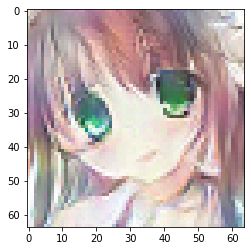

Epoch 1 [0/336] loss_D_real: 0.0098 loss_D_fake: 0.0265 loss_G: 5.8693
Epoch 1 [100/336] loss_D_real: 0.0196 loss_D_fake: 0.0065 loss_G: 5.7573
Epoch 1 [200/336] loss_D_real: 0.0448 loss_D_fake: 0.0046 loss_G: 4.8094
Epoch 1 [300/336] loss_D_real: 0.0986 loss_D_fake: 0.0593 loss_G: 3.2879


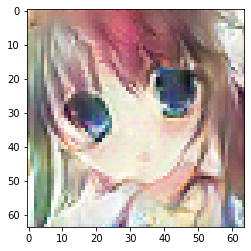

Epoch 2 [0/336] loss_D_real: 0.2284 loss_D_fake: 0.0028 loss_G: 3.3470
Epoch 2 [100/336] loss_D_real: 0.0205 loss_D_fake: 0.0141 loss_G: 6.0494
Epoch 2 [200/336] loss_D_real: 0.0100 loss_D_fake: 0.0224 loss_G: 6.0781
Epoch 2 [300/336] loss_D_real: 0.0673 loss_D_fake: 0.1112 loss_G: 5.4694


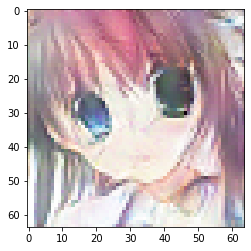

Epoch 3 [0/336] loss_D_real: 0.0092 loss_D_fake: 0.3478 loss_G: 9.5247
Epoch 3 [100/336] loss_D_real: 0.1312 loss_D_fake: 0.4032 loss_G: 4.1850
Epoch 3 [200/336] loss_D_real: 0.1207 loss_D_fake: 0.0031 loss_G: 4.5150
Epoch 3 [300/336] loss_D_real: 0.0134 loss_D_fake: 0.0109 loss_G: 5.8021


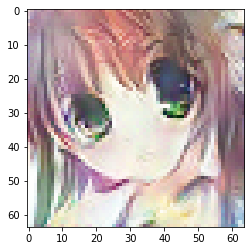

Epoch 4 [0/336] loss_D_real: 0.0155 loss_D_fake: 0.0125 loss_G: 4.8817
Epoch 4 [100/336] loss_D_real: 0.0162 loss_D_fake: 0.0118 loss_G: 5.7761
Epoch 4 [200/336] loss_D_real: 0.0112 loss_D_fake: 0.0153 loss_G: 5.2740
Epoch 4 [300/336] loss_D_real: 0.0047 loss_D_fake: 0.0097 loss_G: 5.7476


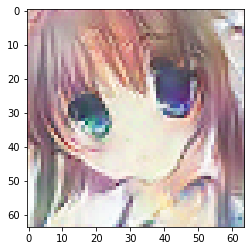

Epoch 5 [0/336] loss_D_real: 0.0212 loss_D_fake: 0.0083 loss_G: 5.0216
Epoch 5 [100/336] loss_D_real: 0.0031 loss_D_fake: 0.0234 loss_G: 6.1954
Epoch 5 [200/336] loss_D_real: 0.0999 loss_D_fake: 1.0155 loss_G: 3.7430
Epoch 5 [300/336] loss_D_real: 0.3770 loss_D_fake: 0.0204 loss_G: 3.3877


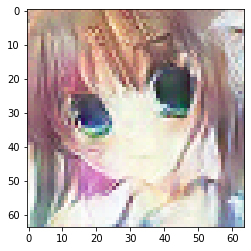

Epoch 6 [0/336] loss_D_real: 0.0284 loss_D_fake: 0.2460 loss_G: 7.2952
Epoch 6 [100/336] loss_D_real: 0.0388 loss_D_fake: 0.0220 loss_G: 5.1024
Epoch 6 [200/336] loss_D_real: 0.0087 loss_D_fake: 0.0316 loss_G: 6.1203
Epoch 6 [300/336] loss_D_real: 0.0309 loss_D_fake: 0.0125 loss_G: 4.4817


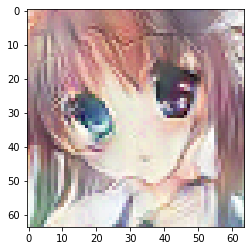

Epoch 7 [0/336] loss_D_real: 0.0107 loss_D_fake: 0.0156 loss_G: 5.7098
Epoch 7 [100/336] loss_D_real: 0.0552 loss_D_fake: 0.4439 loss_G: 3.2932
Epoch 7 [200/336] loss_D_real: 0.1533 loss_D_fake: 0.8105 loss_G: 1.9065
Epoch 7 [300/336] loss_D_real: 0.0612 loss_D_fake: 0.4162 loss_G: 4.8386


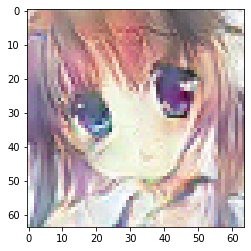

Epoch 8 [0/336] loss_D_real: 0.0873 loss_D_fake: 0.0302 loss_G: 4.8839
Epoch 8 [100/336] loss_D_real: 0.0242 loss_D_fake: 0.0304 loss_G: 5.2602
Epoch 8 [200/336] loss_D_real: 0.0083 loss_D_fake: 0.0498 loss_G: 6.1587
Epoch 8 [300/336] loss_D_real: 0.0315 loss_D_fake: 0.0306 loss_G: 5.1373


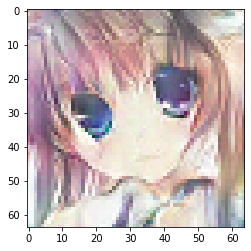

Epoch 9 [0/336] loss_D_real: 0.0200 loss_D_fake: 0.0201 loss_G: 5.3869
Epoch 9 [100/336] loss_D_real: 0.0200 loss_D_fake: 0.0134 loss_G: 5.1204
Epoch 9 [200/336] loss_D_real: 0.0258 loss_D_fake: 0.0043 loss_G: 5.7731
Epoch 9 [300/336] loss_D_real: 0.0192 loss_D_fake: 0.0100 loss_G: 5.6611


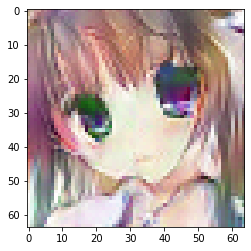

Epoch 10 [0/336] loss_D_real: 0.0102 loss_D_fake: 0.0158 loss_G: 5.6913
Epoch 10 [100/336] loss_D_real: 0.0102 loss_D_fake: 0.0105 loss_G: 5.5725
Epoch 10 [200/336] loss_D_real: 0.1851 loss_D_fake: 0.1076 loss_G: 2.7175


KeyboardInterrupt: 

In [18]:
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader):
        x_real = data.to(device).float()
        real_label = torch.full((x_real.size(0),), REAL_LABEL, device=device, dtype=torch.float)
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device=device, dtype=torch.float)

        netD.zero_grad()
        y_real = netD(x_real)
        loss_D_real = criterion(y_real, real_label)
        loss_D_real.backward()
        
        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        y_fake = netD(x_fake.detach())
        loss_D_fake = criterion(y_fake, fake_label)
        loss_D_fake.backward()
        optimizerD.step()
        
        netG.zero_grad()
        y_fake_r = netD(x_fake)
        loss_G = criterion(y_fake_r, real_label)
        loss_G.backward()
        optimizerG.step()
        
        if i % 100 == 0:
            print('Epoch {} [{}/{}] loss_D_real: {:.4f} loss_D_fake: {:.4f} loss_G: {:.4f}'.format(
            epoch, i, len(dataloader), loss_D_real.mean().item(), loss_D_fake.mean().item(),
            loss_G.mean().item()))
             
    viz_sample = netG(viz_noise).cpu()
    plt.imshow(vutils.make_grid(viz_sample, normalize=True).permute(1,2,0))
    plt.show()

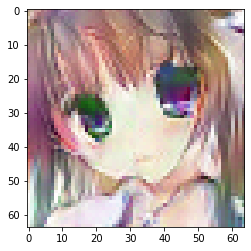

In [19]:
plt.imshow(vutils.make_grid(viz_sample, normalize=True).permute(1,2,0))

In [20]:
type(viz_sample)

torch.Tensor

In [27]:
sample = viz_sample.squeeze(0)

In [29]:
sample = sample.permute(1,2,0)

In [30]:
np.shape(sample)

torch.Size([64, 64, 3])

In [32]:
sample_image1 = sample.detach().numpy()

In [25]:
type(sample_image)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


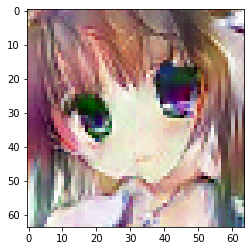

In [33]:
plt.imshow(sample_image1)

In [35]:
import tensorflow_hub as hub
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

2021-10-28 11:41:20.004584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-28 11:41:20.004615: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [36]:
base_model = hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')

input = tf.keras.layers.Input(shape=(None, None, 3), dtype=tf.float32)
net = hub.KerasLayer(base_model)(input)
model = tf.keras.models.Model(input, net)

2021-10-28 11:41:50.393235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-28 11:41:50.398229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-28 11:41:50.398277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2021-10-28 11:41:50.398372: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and 

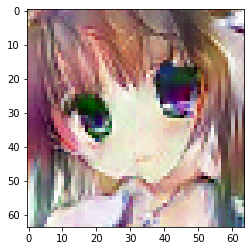

In [37]:
plt.imshow(sample_image1)

In [41]:
type(sample_image1)

numpy.ndarray

In [42]:
sample_image1.astype(dtype=np.float32)

array([[[0.66799426, 0.5702432 , 0.5014336 ],
        [0.7478007 , 0.65784067, 0.57442325],
        [0.7611547 , 0.5533743 , 0.5663296 ],
        ...,
        [0.71157837, 0.61479187, 0.6202713 ],
        [0.8340354 , 0.7391013 , 0.721545  ],
        [0.93075264, 0.92470753, 0.9316187 ]],

       [[0.75676215, 0.6647632 , 0.51967484],
        [0.8649292 , 0.7463307 , 0.7127875 ],
        [0.7185704 , 0.4924066 , 0.47928432],
        ...,
        [0.9591861 , 0.92149806, 0.9151513 ],
        [0.9646232 , 0.9511628 , 0.95306885],
        [0.988405  , 0.98609126, 0.98171455]],

       [[0.86395127, 0.78187317, 0.694925  ],
        [0.7431412 , 0.6167067 , 0.6025899 ],
        [0.6466913 , 0.44099313, 0.4395995 ],
        ...,
        [0.8264902 , 0.8312681 , 0.87088263],
        [0.9934097 , 0.9864619 , 0.99080455],
        [0.99636865, 0.99505216, 0.99571466]],

       ...,

       [[0.9696203 , 0.98318726, 0.97371525],
        [0.8620819 , 0.9472493 , 0.9071338 ],
        [0.5223137 , 0

In [48]:
from PIL import Image

In [50]:
sample_image1 = sample_image1 * 255

In [51]:
sample_image1 = sample_image1.astype(np.uint8)

In [52]:
im = Image.fromarray(sample_image1)

In [54]:
im.save('sample_image.png')